# Analysis of Trades / Filled Orders

## Imports

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import matplotlib.pyplot as plt
from alpaca_trade_api import REST

from live_trader import load_api_keys

## Importing Data

In [326]:
key, secret = load_api_keys()
api = REST(
    key_id=key,
    secret_key=secret,
    base_url="https://paper-api.alpaca.markets"  # paper trading
)

trades = api.get_activities(activity_types="FILL")

df = pd.DataFrame([{
    "symbol": t.symbol,
    "side": t.side,
    "qty": float(t.qty),
    "price": float(t.price),
    "date": pd.to_datetime(t.transaction_time),
} for t in trades])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   symbol  100 non-null    object             
 1   side    100 non-null    object             
 2   qty     100 non-null    float64            
 3   price   100 non-null    float64            
 4   date    100 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 4.0+ KB


In [327]:
# Checking head
df.head()

,symbol,side,qty,price,date
0,INTC,sell,122.0,42.34,2025-12-04 15:31:21.512335+00:00
1,GOOGL,sell,288.0,316.77,2025-12-04 15:31:11.736836+00:00
2,AVGO,sell,2.0,381.74,2025-12-04 15:30:56.785692+00:00
3,PLTR,sell,199.0,176.58,2025-12-04 15:30:36.222296+00:00
4,PLTR,sell,801.0,176.57,2025-12-04 15:30:35.829059+00:00


## Calculating columns

In [328]:
# Calculating PnL
activities = api.get_activities(activity_types="FILL")

rows = []
for a in activities:
    qty = float(a.qty)
    price = float(a.price)

    cash_flow = qty * price
    if a.side == "buy":
        cash_flow = -cash_flow

    rows.append({
        "date": pd.to_datetime(a.transaction_time),
        "symbol": a.symbol,
        "side": a.side,
        "qty": qty,
        "price": price,
        "cash_flow": cash_flow,
    })

df = pd.DataFrame(rows).sort_values("date")
df["realized_pnl"] = df["cash_flow"].cumsum()


In [329]:
history = api.get_portfolio_history(
    period="1A",          # fetch a wide window
    timeframe="1D"
)

equity_df = pd.DataFrame({
    "date": pd.to_datetime(history.timestamp, unit="s", utc=True),
    "equity": history.equity
}).set_index("date")

# Slice the exact date range
equity_window = equity_df.loc[
    "2025-11-25":"2025-12-04"
]

activities = api.get_activities(activity_types="FILL")
rows = []
for a in activities:
    qty = float(a.qty)
    price = float(a.price)

    cash_flow = qty * price
    if a.side == "buy":
        cash_flow = -cash_flow

    rows.append({
        "date": pd.to_datetime(a.transaction_time, utc=True),
        "cash_flow": cash_flow
    })

cash_df = pd.DataFrame(rows).sort_values("date")

starting_cash = 100000  # your initial funding

cash_df["cash_balance"] = starting_cash + cash_df["cash_flow"].cumsum()

combined = equity_df.join(
    cash_df.set_index("date")["cash_balance"],
    how="left"
).ffill()


## Plotting

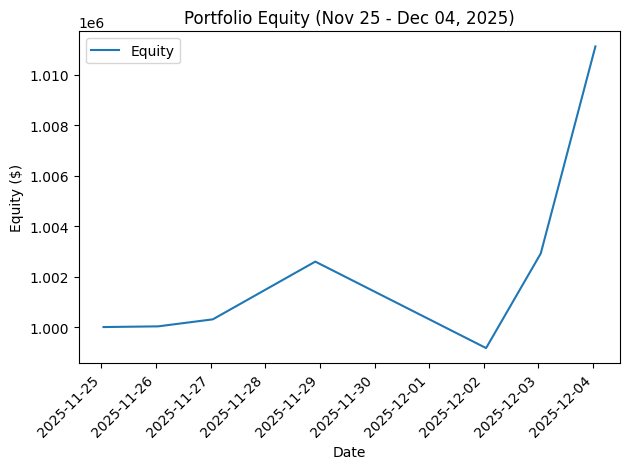

In [ ]:
# Plotting Portfolio-Equity

plt.figure()
plt.plot(equity_window.index, equity_window["equity"], label="Equity")
plt.legend()
plt.title("Portfolio Equity (Nov 25 - Dec 04, 2025)")
plt.xlabel("Date")
plt.ylabel("Equity ($)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

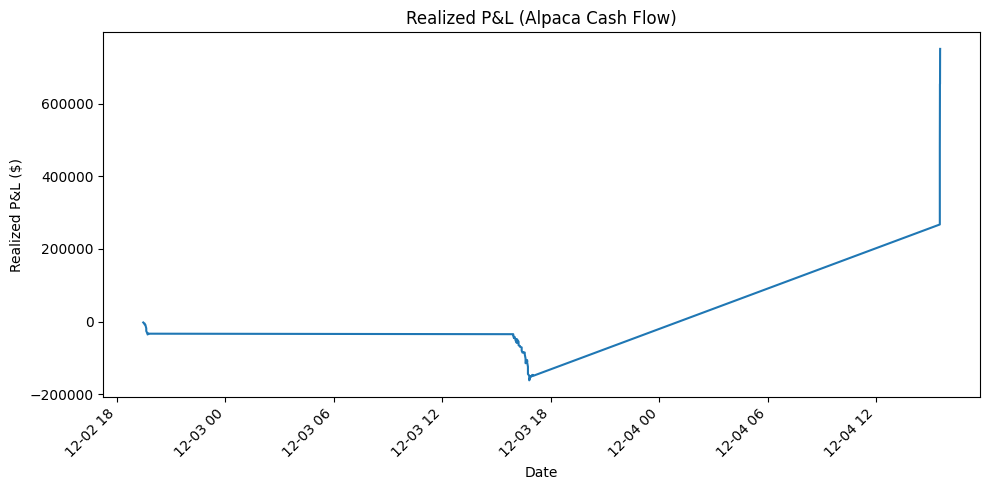

In [ ]:
# Plotting Realized PnL

plt.figure(figsize=(10,5))
plt.plot(df["date"], df["realized_pnl"])
plt.xlabel("Date")
plt.ylabel("Realized P&L ($)")
plt.title("Realized P&L (Alpaca Cash Flow)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()